# 1. Import the essential libraries

In [3]:
conda install -c conda-forge tensorflow

Retrieving notices: ...working... done
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\lukas\anaconda3

  added / updated specs:
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.3.0        |              mkl           3 KB
    abseil-cpp-20211102.0      |       h0e60522_0         2.3 MB  conda-forge
    absl-py-1.4.0              |     pyhd8ed1ab_0         100 KB  conda-forge
    aiohttp-3.8.1              |   py39hb82d6ee_1         545 KB  conda-forge
    aiosignal-1.3.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB



==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.1.0




In [17]:
import os
import glob

import matplotlib.pyplot as plt

import numpy as np

import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

import itertools
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

%matplotlib inline

In [3]:
tf.__version__

'2.9.1'

## 2. Define the required variable

In [4]:
dataset_url = r"C:\Users\lukas\Downloads\EuroSAT\2750"
batch_size = 32 # 32 images processed at the same time
img_height = 64
img_width = 64
validation_split = 0.2 # 20%
rescale = 1.0/255 

# 3. Data preparation for the model

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [6]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode="categorical")

Found 21600 images belonging to 10 classes.


In [7]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                          directory=dataset_url,
                                          shuffle=True,
                                          target_size=(img_height, img_width),
                                          subset="validation",
                                          class_mode="categorical")

Found 5400 images belonging to 10 classes.


# 4. Visualization of input datasets

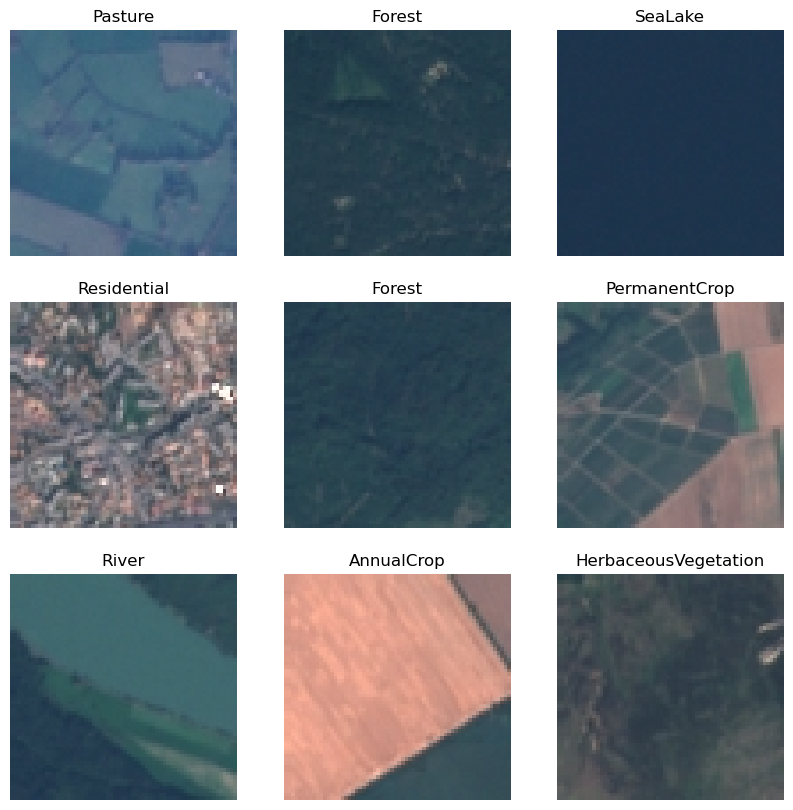

In [10]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# UNQ_C1
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [12]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [13]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# 6. Model train

In [19]:
model = ResNet50(input_shape=(64,64,3), classes=10)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_107 (Conv2D)            (None, 32, 32, 64)   9472        ['zero_padding2d_3[0][0]']       
                                                                                                  
 batch_normalization_107 (Batch  (None, 32, 32, 64)  256         ['conv2d_107[0][0]']       

                                                                                                  
 conv2d_117 (Conv2D)            (None, 15, 15, 256)  16640       ['activation_107[0][0]']         
                                                                                                  
 batch_normalization_117 (Batch  (None, 15, 15, 256)  1024       ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_34 (Add)                   (None, 15, 15, 256)  0           ['activation_105[0][0]',         
                                                                  'batch_normalization_117[0][0]']
                                                                                                  
 activation_108 (Activation)    (None, 15, 15, 256)  0           ['add_34[0][0]']                 
          

 add_37 (Add)                   (None, 8, 8, 512)    0           ['activation_114[0][0]',         
                                                                  'batch_normalization_127[0][0]']
                                                                                                  
 activation_117 (Activation)    (None, 8, 8, 512)    0           ['add_37[0][0]']                 
                                                                                                  
 conv2d_128 (Conv2D)            (None, 8, 8, 128)    65664       ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_128 (Batch  (None, 8, 8, 128)   512         ['conv2d_128[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_138 (Batch  (None, 4, 4, 256)   1024        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_127 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_127[0][0]']         
                                                                                                  
 batch_normalization_139 (Batch  (None, 4, 4, 256)   1024        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
          

 activation_137 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 4, 4, 1024)   263168      ['activation_137[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 4, 4, 1024)  4096        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_44 (Add)                   (None, 4, 4, 1024)   0           ['activation_135[0][0]',         
                                                                  'batch_normalization_149[0][0]']
                                                                                                  
 activatio

                                                                                                  
 add_47 (Add)                   (None, 2, 2, 2048)   0           ['activation_144[0][0]',         
                                                                  'batch_normalization_159[0][0]']
                                                                                                  
 activation_147 (Activation)    (None, 2, 2, 2048)   0           ['add_47[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_147[0][0]']         
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
          

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# please increase the epoch for higher accuraacy (epochs = 100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
675/675 [==============================] - 2110s 3s/step - loss: 1.3755 - accuracy: 0.5727 - val_loss: 1.1428 - val_accuracy: 0.6109
Epoch 2/20
675/675 [==============================] - 2413s 4s/step - loss: 0.8789 - accuracy: 0.7011 - val_loss: 0.9868 - val_accuracy: 0.6770
Epoch 3/20
675/675 [==============================] - 2279s 3s/step - loss: 0.9124 - accuracy: 0.6915 - val_loss: 0.9287 - val_accuracy: 0.6746
Epoch 4/20
675/675 [==============================] - 2300s 3s/step - loss: 0.7447 - accuracy: 0.7572 - val_loss: 0.7353 - val_accuracy: 0.7539
Epoch 5/20
675/675 [==============================] - 2396s 4s/step - loss: 0.6871 - accuracy: 0.7842 - val_loss: 0.8007 - val_accuracy: 0.7393
Epoch 6/20
675/675 [==============================] - 2782s 4s/step - loss: 0.6003 - accuracy: 0.8095 - val_loss: 0.6787 - val_accuracy: 0.7691
Epoch 7/20
675/675 [==============================] - 2699s 4s/step - loss: 0.5348 - accuracy: 0.8306 - val_loss: 1.5686 - val_accuracy:

In [24]:
model.save(r"model/model_100_epoch.h5")

# 9. Load Model

In [25]:
from tensorflow.keras.models import load_model
model = load_model(r"model/model_100_epoch.h5")

# 10. Analyzing Results and Visualization

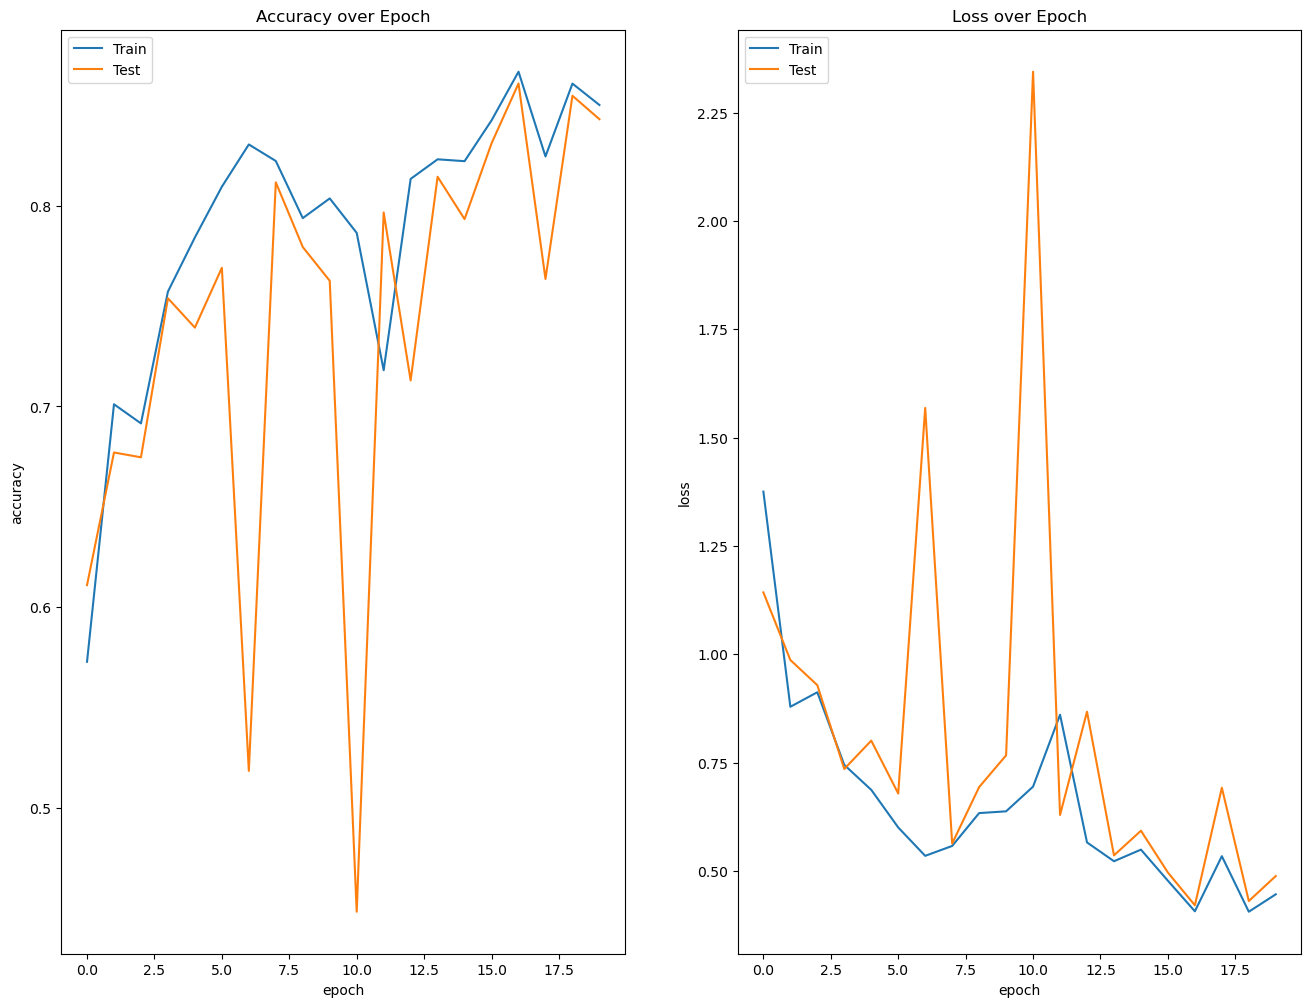

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
ax1.plot(history.history["accuracy"])
ax1.plot(history.history["val_accuracy"])
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.set_title("Accuracy over Epoch")
ax1.legend(["Train", "Test"], loc="upper left")

ax2.plot(history.history["loss"])
ax2.plot(history.history["val_loss"])
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.set_title("Loss over Epoch")
ax2.legend(["Train", "Test"], loc="upper left")

# 11. Confusion Matrix

In [28]:
y_pred = [] # store predicted labels
y_true = [] # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset): # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = 1))
    if i==300:
        break
        
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis = 1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


In [29]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 900,    8,   22,   13,    0,   17,   29,    0,   58,   11],
       [   2, 1024,    4,    1,    0,   29,    3,    0,    7,    4],
       [  37,   25,  783,   19,   17,   25,   94,   38,   24,    3],
       [  32,    1,   20,  679,   65,    9,   20,   13,   58,    0],
       [   1,    0,    9,   12,  853,    0,    0,   24,    2,    0],
       [  26,   22,   17,   10,    0,  556,   21,    1,   51,    8],
       [ 101,    0,   79,   27,   15,   33,  596,   11,   29,    0],
       [   0,    0,   12,    1,   47,    1,   19, 1001,    1,    0],
       [  19,   18,   24,   34,   10,   15,   18,    5,  750,    2],
       [   4,   92,    5,    0,    0,    2,    0,    1,   11,  934]],
      dtype=int64)

In [34]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Confusion Matrix",
                         figsize=(10,10),
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[ 900    8   22   13    0   17   29    0   58   11]
 [   2 1024    4    1    0   29    3    0    7    4]
 [  37   25  783   19   17   25   94   38   24    3]
 [  32    1   20  679   65    9   20   13   58    0]
 [   1    0    9   12  853    0    0   24    2    0]
 [  26   22   17   10    0  556   21    1   51    8]
 [ 101    0   79   27   15   33  596   11   29    0]
 [   0    0   12    1   47    1   19 1001    1    0]
 [  19   18   24   34   10   15   18    5  750    2]
 [   4   92    5    0    0    2    0    1   11  934]]


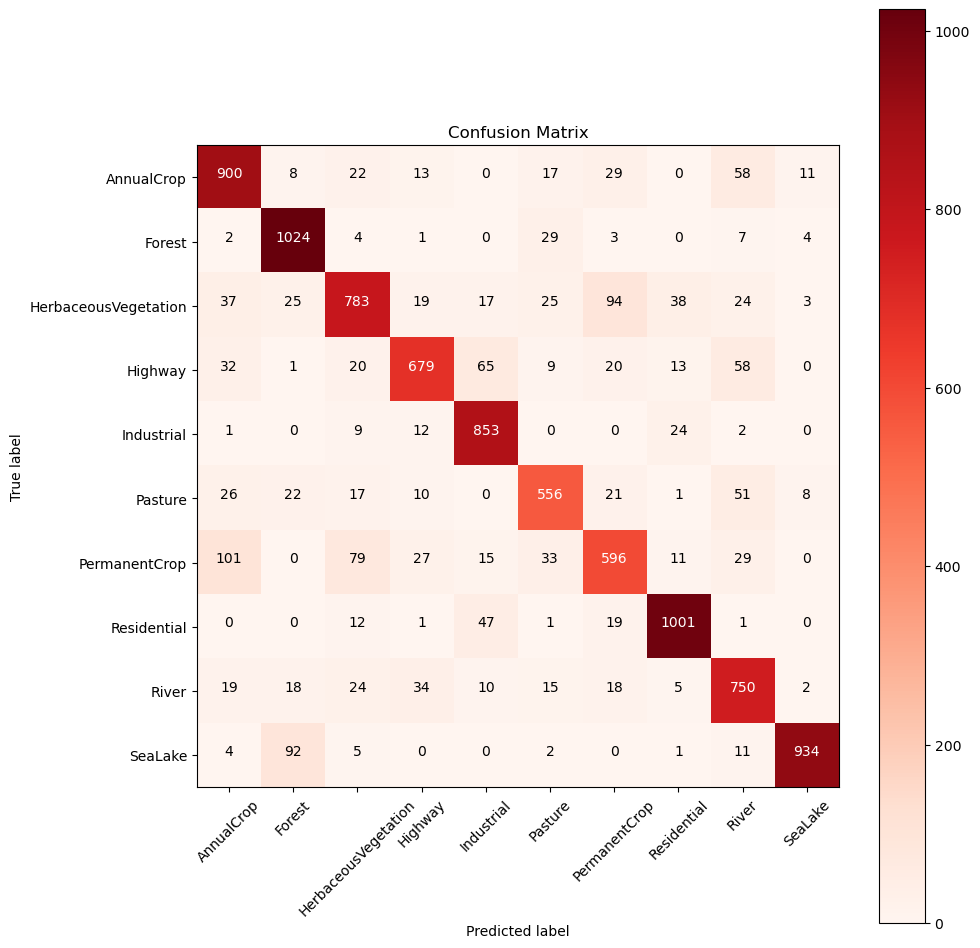

In [35]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap="Reds")